In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import pandas as pd
import scipy.stats
import scanpy_helpers as sh
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os

sc.set_figure_params(figsize=(5, 5))

## Load data

In [3]:
adata = sc.read_h5ad("../../data/30_merge_adata/adata_scvi_annotated.h5ad")
artifact_dir = "../../data/70_downstream_analyses/gene_expression"

In [4]:
os.makedirs(artifact_dir, exist_ok=True)

In [ ]:
adata.obs.columns

Index(['patient', 'timepoint', 'sample', 'n_genes_by_counts', 'total_counts',
       'total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_genes',
       'patient_id', 'sex', 'age', 'ethnicity', 'response', 'leiden',
       'leiden_scvi', 'cell_type'],
      dtype='object')

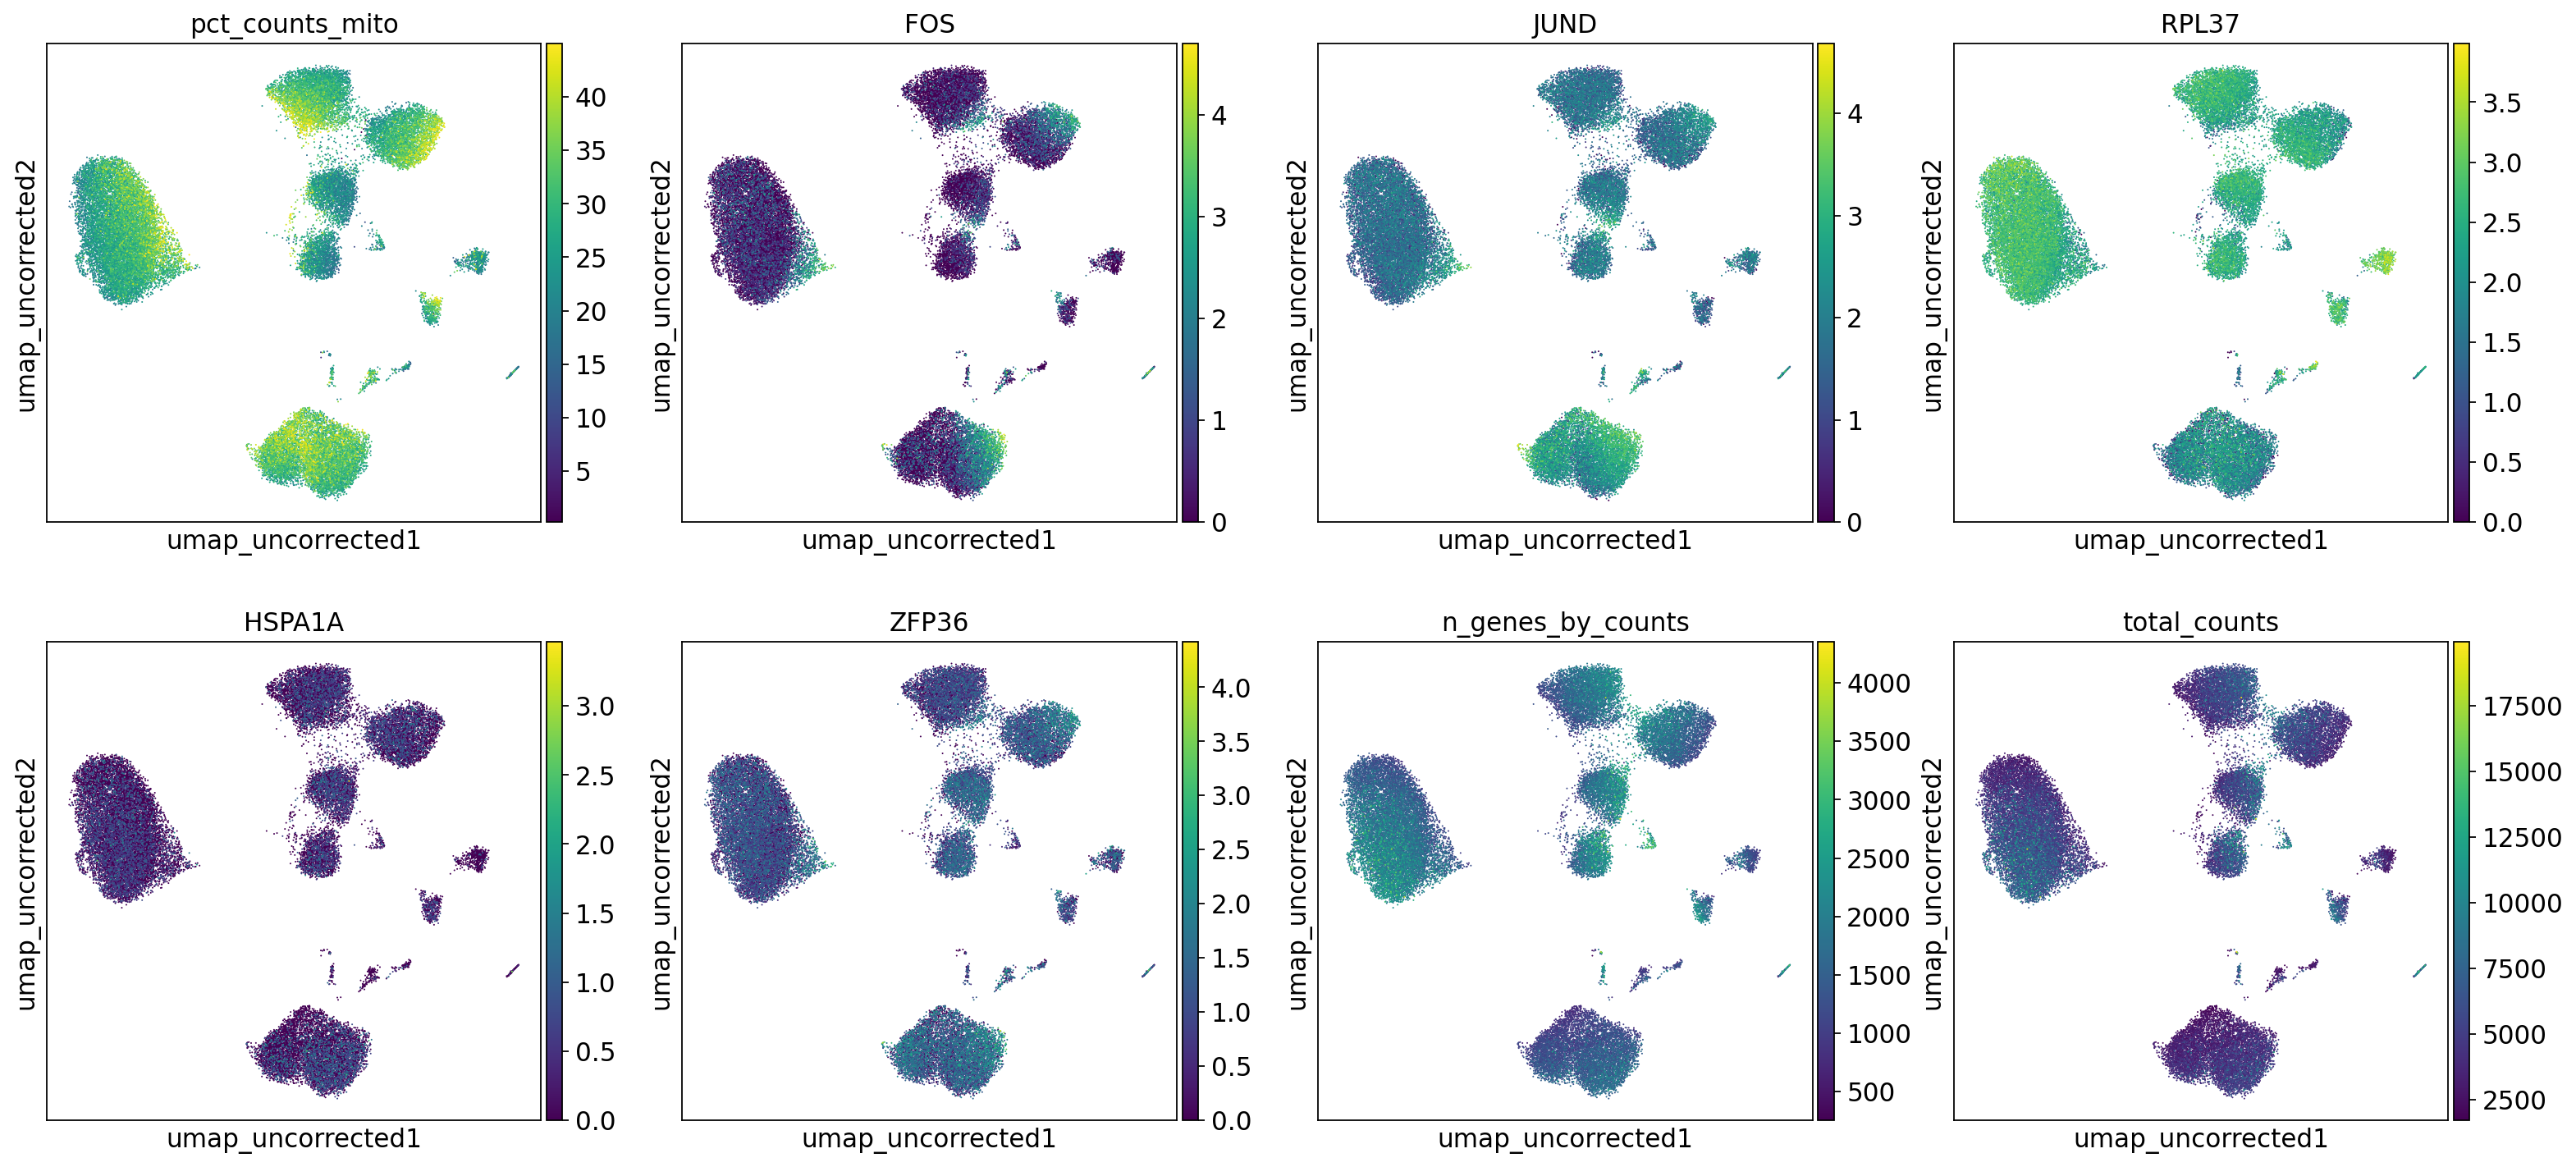

In [6]:
# plot fos/jun markers and covariates
sc.pl.embedding(
    adata,
    basis="umap_uncorrected",
    color=[
        "pct_counts_mito",
        "FOS",
        "JUND",
        "RPL37",
        "HSPA1A",
        "ZFP36",
        "n_genes_by_counts",
        "total_counts",
    ],
)

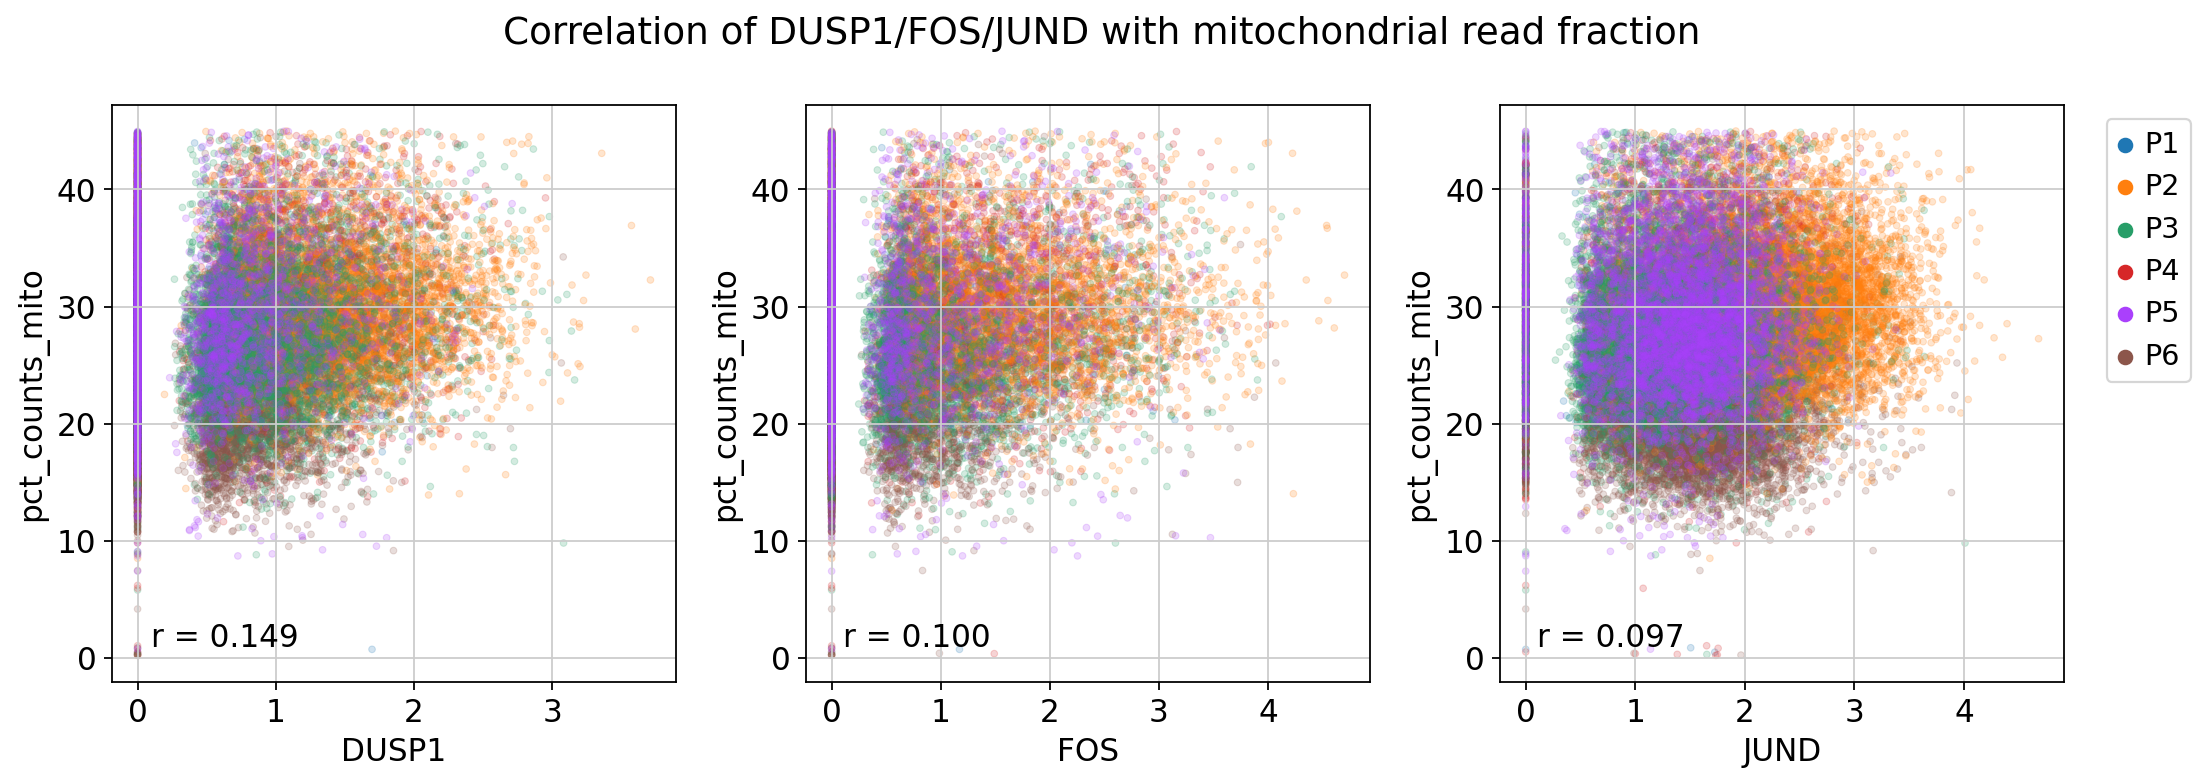

In [7]:
GENES = ["DUSP1", "FOS", "JUND"]
tmp_df = sc.get.obs_df(adata, ["pct_counts_mito", *GENES, "patient"])
corr_dict= {
    gene: scipy.stats.pearsonr(tmp_df[gene], tmp_df["pct_counts_mito"])[0] for gene in GENES
}
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
for gene, ax in zip(GENES, axs):
    sns.scatterplot(data=tmp_df, x=gene, y="pct_counts_mito", hue="patient", marker=".", ax=ax, alpha=0.2, edgecolor=None)
    ax.text(0.1, 1, f"r = {corr_dict[gene]:.3f}")
    if gene != "JUND":
        ax.legend().remove()
    else:
        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.suptitle(f"Correlation of {'/'.join(GENES)} with mitochondrial read fraction")
fig.tight_layout()
fig.savefig(artifact_dir + "/mitochondrial_correlation.pdf", bbox_inches="tight")

# Top Genes healhty vs HCL cell

In [8]:
de_genes = pd.read_csv(
    "../../data/50_de_analysis/deseq2_results/deseq2_res_bulk_healthy_malignant/HCL cell_healthy B cell_IHWallGenes.tsv",
    sep="\t",
)

In [9]:
top_genes = (
    de_genes.assign(
        direction=lambda x: ["up" if _ > 0 else "down" for _ in x["log2FoldChange"]]
    )
    .groupby("direction")
    .apply(lambda x: x.head(15))
)

In [10]:
pb_b_cells = sh.pseudobulk.pseudobulk(
    adata[adata.obs["cell_type"].isin(["HCL cell", "healthy B cell"]), :],
    layer="raw_counts",
    groupby=["patient", "cell_type"],
)

In [11]:
sc.pp.normalize_total(pb_b_cells, target_sum=1e6)

In [12]:
sc.pp.log1p(pb_b_cells, base=2)

## Matrixplot with zscores

In [13]:
pb_b_cells.layers["z_scores"] = scipy.stats.zscore(pb_b_cells.X, axis=0)

/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'patient' as categorical
/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


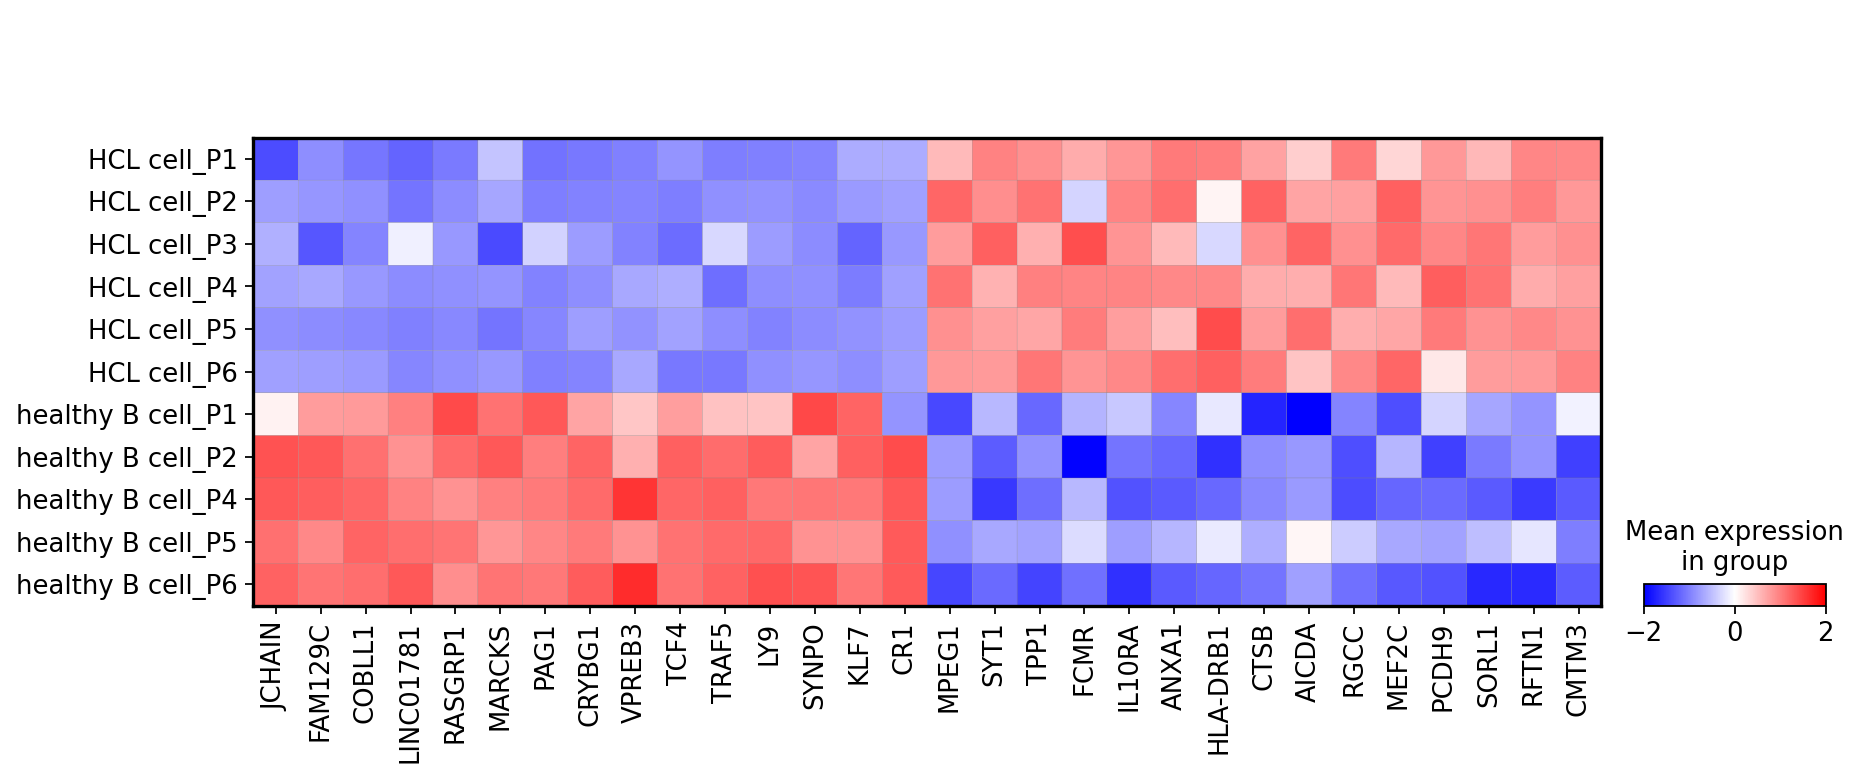

In [14]:
fig = sc.pl.matrixplot(
    pb_b_cells,
    var_names=top_genes["gene_id"],
    groupby=["cell_type", "patient"],
    cmap="bwr",
    vmin=-2,
    vmax=2,
    layer="z_scores",
    return_fig=True
)
fig.savefig(f"{artifact_dir}/healthy_malignant_b_cells_pseudobulk_zscore_heatmap.pdf", bbox_inches="tight")

### fold change plot

In [15]:
top_genes

gene_id      baseMean  log2FoldChange     lfcSE       stat  \
direction                                                                    
down      0      JCHAIN    360.843108       -6.904980  0.210982 -32.727867   
          1     FAM129C    444.406146       -7.092070  0.262399 -27.027839   
          2      COBLL1    130.274810       -7.716855  0.339937 -22.700825   
          3   LINC01781    237.420641       -8.298305  0.370869 -22.375322   
          4     RASGRP1    156.444346       -8.139503  0.368823 -22.068841   
          5      MARCKS    219.742814       -5.530064  0.254038 -21.768674   
          6        PAG1     82.760564       -7.924590  0.418290 -18.945186   
          7      CRYBG1    105.879841       -6.843632  0.370017 -18.495476   
          8      VPREB3     77.727237       -7.412540  0.405461 -18.281736   
          9        TCF4    302.161912       -6.148370  0.344001 -17.873105   
          10      TRAF5    129.651004       -4.847661  0.291757 -16.615378   
          11        LY9     59.021948       -8.181415  0.501192 -16.323930   
          12      SYNPO     63.931069       -8.251796  0.518404 -15.917695   
          13       KLF7     69.147891       -5.027131  0.318020 -15.807585   
          14        CR1     46.003827       -8.073476  0.525006 -15.377876   
up        24      MPEG1   1347.884386        2.164593  0.163953  13.202538   
          37       SYT1    544.627654        3.611922  0.331959  10.880619   
          41       TPP1   1433.171231        1.972074  0.183787  10.730230   
          45       FCMR   3982.682852        1.237029  0.117756  10.504991   
          49     IL10RA    858.711650        2.314779  0.224291  10.320409   
          53      ANXA1    567.020545        4.202170  0.420666   9.989318   
          56   HLA-DRB1  12280.636704        1.421775  0.145076   9.800195   
          57       CTSB    692.026682        2.426416  0.247699   9.795836   
          59      AICDA    576.240485        3.804648  0.390635   9.739656   
          63       RGCC    689.980278        3.688282  0.384541   9.591394   
          64      MEF2C   1571.161169        1.565023  0.164114   9.536178   
          66      PCDH9   1243.864951        2.483662  0.261804   9.486726   
          67      SORL1    568.733852        3.380500  0.357449   9.457292   
          68      RFTN1    634.918014        2.810392  0.297976   9.431611   
          69      CMTM3    341.883909        3.415722  0.365945   9.333975   

                     pvalue           padj    weight  gene_name  \
direction                                                         
down      0   6.270861e-235  5.470766e-231  1.829528     JCHAIN   
          1   6.959767e-161  2.746174e-157  2.022539    FAM129C   
          2   4.396694e-114  1.153978e-110  2.027065     COBLL1   
          3   6.846229e-111  1.256363e-107  2.174384  LINC01781   
          4   6.298485e-108  1.151875e-104  1.745504    RASGRP1   
          5   4.597346e-105  6.023749e-102  2.030248     MARCKS   
          6    4.838774e-80   5.706937e-77  1.933278       PAG1   
          7    2.245502e-76   2.257923e-73  1.984150     CRYBG1   
          8    1.156847e-74   1.011495e-71  2.028290     VPREB3   
          9    1.910564e-71   1.666797e-68  1.829528       TCF4   
          10   5.393369e-62   4.483393e-59  1.745504      TRAF5   
          11   6.670003e-60   9.548049e-57  0.929159        LY9   
          12   4.776493e-57   3.033414e-54  1.933278      SYNPO   
          13   2.758388e-56   1.626646e-53  1.933278       KLF7   
          14   2.303806e-53   2.887590e-50  0.848944        CR1   
up        24   8.482832e-40   2.677714e-37  2.022539      MPEG1   
          37   1.425918e-27   2.961245e-25  2.022539       SYT1   
          41   7.341317e-27   1.347218e-24  2.174384       TPP1   
          45   8.193039e-26   1.553847e-23  1.829528       FCMR   
          49   5.697978e-25   8.959043e-23  2.030248     IL10RA   
          53   1.697450e-23   2.742358e-21  1

In [16]:
custom_genes = sorted("""
    IL1R2 HLA-DRB1 HLA-DQA1 S100A4 GAS7 TACC1 CKLF HLA-DRA PCDH9 HLA-DRB5
    HOPX ANXA1 DUSP6 RGCC HLA-DQB1 IL10RA TPP1 SDC3 SIX3 SORL1 RFTN1 GDI2 
    LAPTM5 IL2RA MPEG1 MTSS1 RGS13 LBH AICDA
""".split())

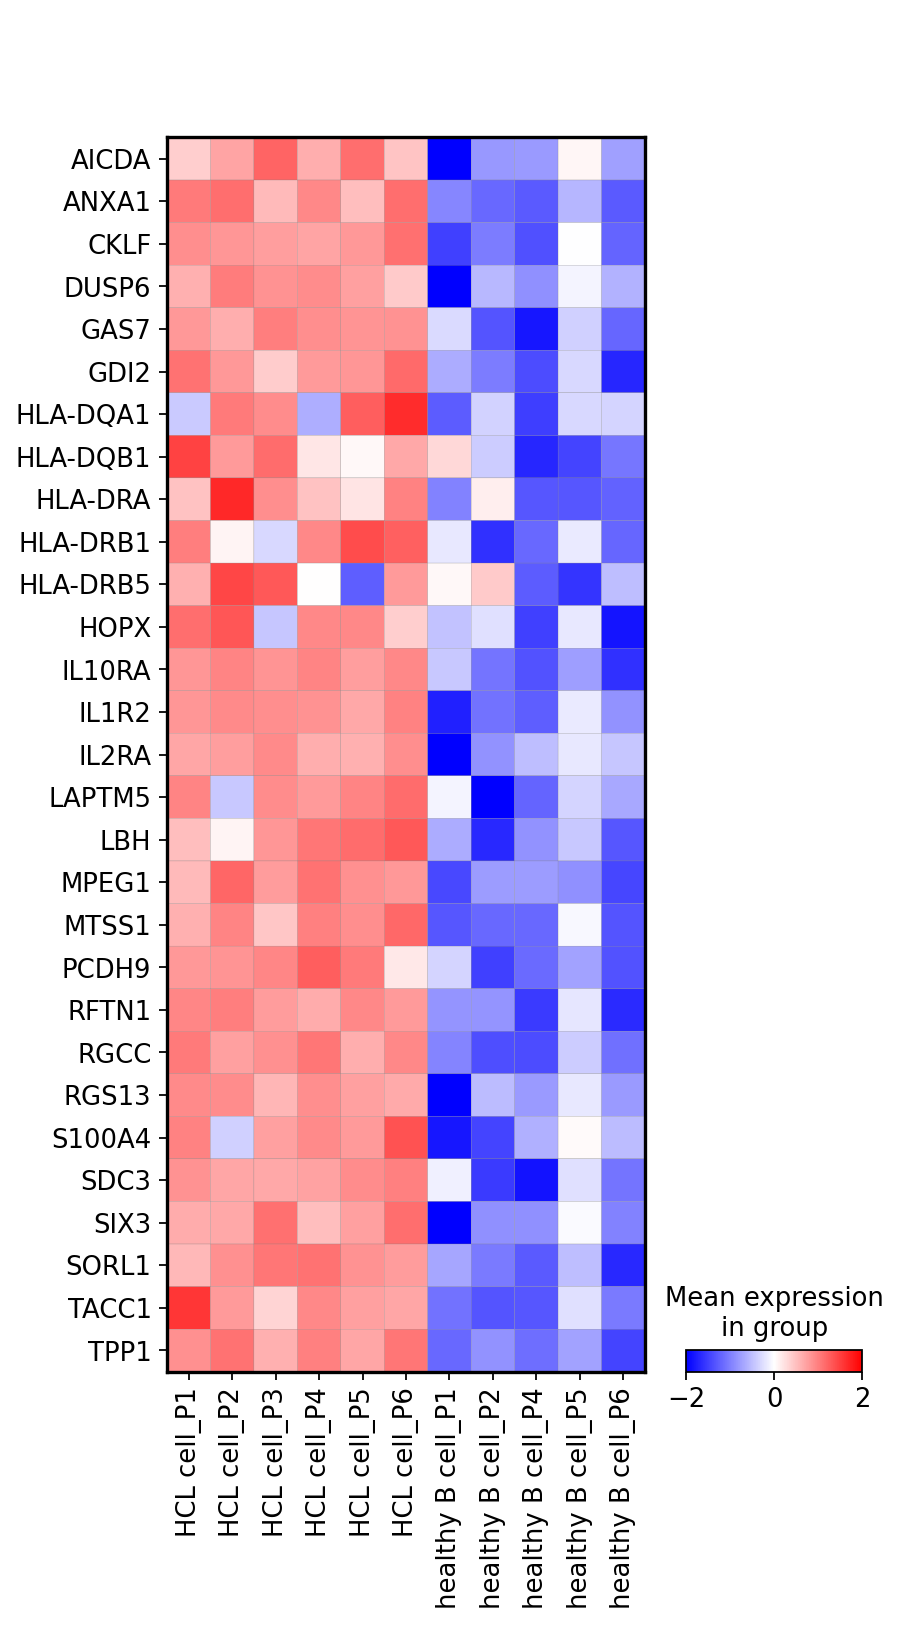

In [17]:
fig = sc.pl.matrixplot(
    pb_b_cells,
    var_names=custom_genes,
    groupby=["cell_type", "patient"],
    cmap="bwr",
    vmin=-2,
    vmax=2,
    layer="z_scores",
    return_fig=True,
    swap_axes=True
)
fig.savefig(f"{artifact_dir}/healthy_malignant_b_cells_pseudobulk_zscore_heatmap_custom_genes.pdf", bbox_inches="tight")

In [18]:
ch = sh.pairwise.plot_paired_fc(
    pb_b_cells[:, top_genes["gene_id"]],
    groupby="cell_type",
    paired_by="patient",
    metric="diff",
    de_res_df=top_genes,
    metric_name="log2(fold change)"
)

/home/sturm/projects/2021/hairy_cell_leukemia_wolf/lib/scanpy_helpers/scanpy_helpers/pairwise.py:51: UserWarning: You are plotting more than 20 variables which may be slow. Explicitly set the `var_names` parameter to turn this off. 
  warnings.warn(
/home/sturm/projects/2021/hairy_cell_leukemia_wolf/lib/scanpy_helpers/scanpy_helpers/pairwise.py:80: UserWarning: 1 unpaired samples removed
  warnings.warn(f"{removed_samples} unpaired samples removed")


In [19]:
ch.display()

alt.LayerChart(...)